# Test masking with clumping verse straight masking
#### With both Old and new gradient
    
In this notebook we assess the change in handling the weighted mask for Condition #2 of Figueria et al 2016.

For that paper the spectrum is broken into several small spectra on regions masked telluric lines (>2%).

The updated version just applies a boolen mask after pixel weights are calculated.

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from eniric.atmosphere import Atmosphere
from eniric.legacy import mask_clumping, RVprec_calc_masked
from eniric_scripts.aces_precision import convolve_and_resample
from eniric.snr_normalization import normalize_flux
from eniric import Qcalculator as Q
from eniric.utilities import band_limits, load_aces_spectrum, wav_selector


In [12]:
wav_, flux_ = load_aces_spectrum([3900, 4.5, 0,0])
# Small section in K bands to experiment with 
wav, flux  =  wav_selector(wav_, flux_, 2.1025, 2.1036)


In [13]:
# Telluric mask
atm_ = Atmosphere.from_band("K", bary=True)

atm = atm_.at(wav)
mask = atm.mask


# Visuallize the Pixel Weights:

In [14]:
# Clumping method
wclump, fclump = mask_clumping(wav, flux, mask)
print("# Number of clumps = ", len(wclump))
# print(wclump, fclump)

print(len(wclump))

# Number of clumps =  2
2


In [15]:
wis_0 = Q.pixel_weights(wav, flux, grad=False) 
wis_1 = Q.pixel_weights(wav, flux, grad=True) 
wis_0 *= mask[:-1]
wis_1 *= mask

wis_0[wis_0 == 0] = np.nan
wis_1[wis_1 == 0] = np.nan

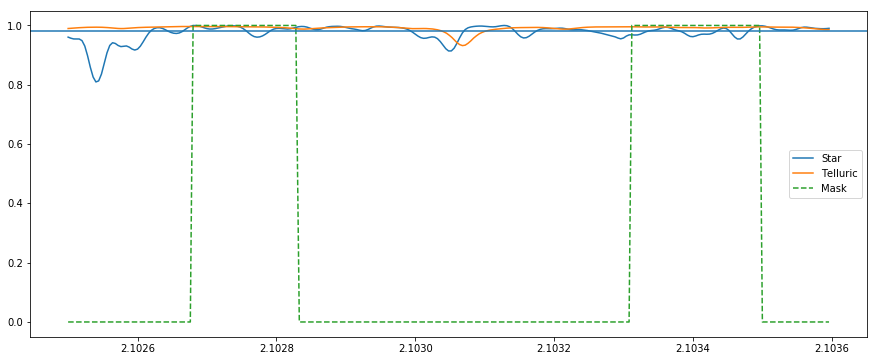

In [16]:
plt_setting = {"figsize":(15,6)}
plt.figure(**plt_setting)
plt.plot(wav,flux/np.max(flux), label="Star")
plt.plot(atm.wl, atm.transmission, label="Telluric")
plt.plot(atm.wl, atm.mask, "--", label="Mask")
plt.axhline(0.98)

plt.legend()

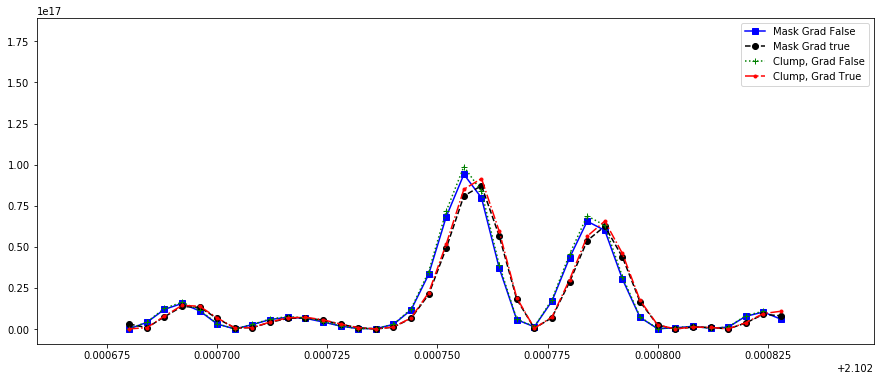

In [17]:
plt.figure(**plt_setting)

plt.plot(wav[:-1], wis_0, "bs-",label= "Mask Grad False")
plt.plot(wav, wis_1, "ko--",label= "Mask Grad true")

w, f = (wclump[0],fclump[0])
wis1 = Q.pixel_weights(w,f,grad=True)
wis0 = Q.pixel_weights(w,f, grad=False)

plt.plot(w[:-1], wis0*1.05, "g+:", label="Clump, Grad False") 
plt.plot(w, wis1*1.05, "r.-.", label="Clump, Grad True")
plt.legend()
plt.xlim(wclump[0][0]*0.99999, wclump[0][-1]*1.00001)
plt.show()
    

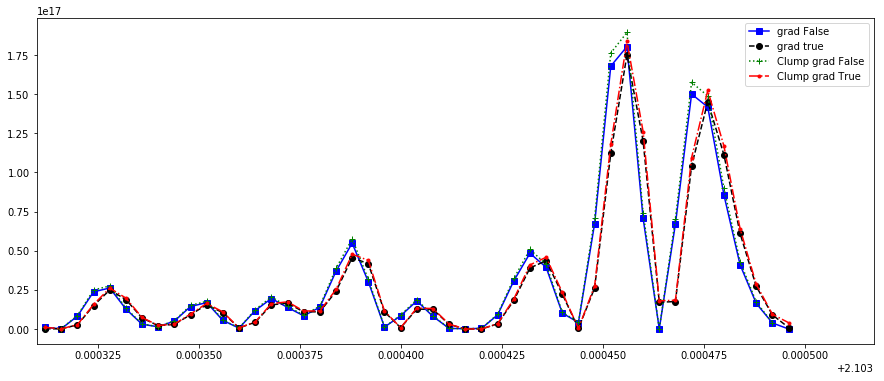

In [18]:
plt.figure(**plt_setting)

plt.plot(wav[:-1], wis_0, "bs-",label= "grad False")
plt.plot(wav, wis_1, "ko--",label= "grad true")
w, f = (wclump[1],fclump[1])
wis1 = Q.pixel_weights(w,f, grad=True)
wis0 = Q.pixel_weights(w,f, grad=False)

plt.plot(w[:-1], wis0*1.05, "g+:", label="Clump grad False") 
plt.plot(w, wis1*1.05, "r.-.", label="Clump grad True")
plt.legend()
plt.xlim(wclump[-1][0]*0.999999, wclump[-1][-1]*1.00001)

plt.show()

Ffrom these two examples the calculations with the same gradients produces the same pixel weights The clumped version produces less weight though.

The masked version produces slightly different value for the last pixel due to how it is calculated. 
With the new graident all pixels are kept except in the clumped version the last pixel s the end and not in the middle so is not calculated with central difference but finite backward difference. 

# Calculations of RV

In [19]:
print(RVprec_calc_masked(wav, flux, atm.mask, grad=True))
print(Q.RVprec_calc(wav, flux, atm.mask, grad=True))
print(RVprec_calc_masked(wav, flux, atm.mask, grad=False))
print(Q.RVprec_calc(wav, flux, atm.mask, grad=False))


0.21166150948144796 m / s
0.21182767928550914 m / s
0.2053261503793021 m / s
0.20503991562376514 m / s


Differences between versions with same gradient is at the 4th sf. These are not the correct scale, this will be addressed in the next section.

# Calculating difference ratios.

Assessing the changes to actual Figueira et al. values by not splitting on telluric lines first then applying mask to the weigths, or slitting then calculating weigths.

Convolving the spectra to vsini=1 an R=100k of a M0 spectra in the Z,Y,J,H,K bands to be consistent with paper. 
Using Old gradient and new gradient methods to access difference.
The old gradient drops the last pixel, which drops many pixels when spectra is split between telluric lines.

In [20]:
 # Explore relative difference of different bands
wav_, flux_ = load_aces_spectrum([3900, 4.5, 0,0])
wav, flux = wav_selector(wav_, flux_, 0.7, 2.5)

table = []
table.append("Band, Cond#1, Masked, Weighted, ratio,   cond#1, Masked, Weighted, ratio")
table.append("Grad,              False             ,                True              ")

for band in ["Z", "Y", "J", "H", "K"]:
    atm = Atmosphere.from_band(band, bary=True)
    
    w, f = convolve_and_resample(wav, flux, vsini=1, R=100000, band=band, sampling=3)
    f = normalize_flux(f, id_string="M0-{}-1.0-100k".format(band), snr=100,ref_band="J")
    atm = atm.at(w)
    
    a = RVprec_calc_masked(w, f, atm.mask, grad=True)
    b = RVprec_calc_masked(w, f, atm.mask, grad=False)
    c = Q.RVprec_calc(w, f, atm.mask, grad=True)
    d = Q.RVprec_calc(w, f, atm.mask, grad=False)
    e = Q.RVprec_calc(w, f,  grad=True)
    f = Q.RVprec_calc(w, f,  grad=False)
    
    false_ratio = (d-b)/b
    true_ratio = (c-a)/a
    table.append("{0:5}, {1:4.02f}, {2:6.02f}, {3:6.02f}, {4:5.04f}, {5:6.02f}, {6:6.02f}, {7:6.02f}, {8:5.04f}".format(
        band, f.value, b.value, d.value, false_ratio, e.value, a.value, c.value, true_ratio))


Starting the Rotation convolution for vsini=1.00...


100%|████████████████████████████████████████████████████████████████████████| 100087/100087 [01:27<00:00, 1148.39it/s]


Starting the Resolution convolution...


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [01:13<00:00, 1366.17it/s]


	Sanity Check: The reference S/N at 1.25 was of 160742.28.
M0-Z-1.0-100k normalization constant = 2583808.000000
Starting the Rotation convolution for vsini=1.00...


100%|██████████████████████████████████████████████████████████████████████████| 50077/50077 [00:22<00:00, 2253.66it/s]


Starting the Resolution convolution...


100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:22<00:00, 2189.02it/s]


	Sanity Check: The reference S/N at 1.25 was of 160742.28.
M0-Y-1.0-100k normalization constant = 2583808.000000
Starting the Rotation convolution for vsini=1.00...
Starting the Resolution convolution...
	Sanity Check: The reference S/N at 1.25 was of 160742.28.
M0-J-1.0-100k normalization constant = 2583808.000000
Starting the Rotation convolution for vsini=1.00...
Starting the Resolution convolution...
	Sanity Check: The reference S/N at 1.25 was of 160742.28.
M0-H-1.0-100k normalization constant = 2583808.000000
Starting the Rotation convolution for vsini=1.00...
Starting the Resolution convolution...
	Sanity Check: The reference S/N at 1.25 was of 160742.28.
M0-K-1.0-100k normalization constant = 2583808.000000


In [21]:
for line in table:
    print(line)

Band, Cond#1, Masked, Weighted, ratio,   cond#1, Masked, Weighted, ratio
Grad,              False             ,                True              
Z    , 4.48,   7.42,   7.38, -0.0066,   4.73,   7.76,   7.77, 0.0013
Y    , 3.96,   4.75,   4.74, -0.0022,   4.23,   5.06,   5.06, 0.0006
J    , 7.45,  18.58,  18.53, -0.0029,   7.84,  19.57,  19.57, 0.0001
H    , 3.82,   6.08,   6.05, -0.0053,   3.96,   6.25,   6.26, 0.0008
K    , 7.12,  32.21,  32.14, -0.0022,   7.42,  33.48,  33.49, 0.0005


This table shows that the methods produce very similar results. With new gradient it is 0.01 % difference.


This confirms that the new weighted mask is suitable.
Clumping method is needed to confirm old results. ???? Is it???